<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/TESS/TOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# just in case if needed
!pip install catboost
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


## Prerequisities

In [3]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [4]:
toi = pd.read_csv('TOI_Data.csv', comment='#')

## Feature Selection

In [5]:
features = [
    "tfopwg_disp",
    "pl_orbper",
    "pl_trandurh",
    "pl_trandep",
    "pl_rade",
    "pl_insol",
    "pl_eqt",
    "st_tmag",
    "st_dist",
    "st_teff",
    "st_rad",
    "st_logg"
]

drop_list = [
    "toi", "tid",
    "rastr", "ra", "decstr", "dec",
    "st_pmra", "st_pmraerr1", "st_pmraerr2", "st_pmralim",
    "st_pmdec", "st_pmdecerr1", "st_pmdecerr2", "st_pmdeclim",
    "pl_tranmid", "pl_tranmiderr1", "pl_tranmiderr2", "pl_tranmidlim",
    "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim",
    "pl_trandurherr1", "pl_trandurherr2", "pl_trandurhlim",
    "pl_trandeperr1", "pl_trandeperr2", "pl_trandeplim",
    "pl_radelim",
    "st_tmagerr1", "st_tmagerr2", "st_tmaglim",
    "st_disterr1", "st_disterr2", "st_distlim",
    "st_tefferr1", "st_tefferr2", "st_tefflim",
    "st_logglim",
    "st_radlim",
    "toi_created", "rowupdate",

    # Missing Data
    "pl_radeerr1", "pl_radeerr2",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim",
    "st_loggerr1", "st_loggerr2",
    "st_raderr1", "st_raderr2"
]


In [6]:
toi = toi[features]

Label Mapping

In [7]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 0,   # Planetary Candidate
    "APC": 0,  # Ambiguous Planetary Candidate
    "FP": -1,  # False Positive
    "FA": -1   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

In [8]:
for col in features:
    toi[col].fillna(toi[col].median(), inplace=True)

/tmp/ipython-input-1020813461.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi[col].fillna(toi[col].median(), inplace=True)


### Diagnoise

In [ ]:
#print(toi.isna().sum()[toi.isna().sum() > 0])
#for col in features:
#    print(toi[col].dtype)

## Defining data sets

In [9]:
X = toi.drop("tfopwg_disp", axis=1)
y = toi["tfopwg_disp"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [11]:
classes = np.unique(y_train)

Calculating Class Weights

In [12]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [13]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [15]:
max_ite = 3000
dep = 8
l_rate = 0.08

In [16]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    border_count=1024,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [17]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0716857	test: 1.0716878	best: 1.0716878 (0)	total: 160ms	remaining: 7m 58s
50:	learn: 0.7511241	test: 0.7602014	best: 0.7602014 (50)	total: 5.55s	remaining: 5m 21s
100:	learn: 0.6741030	test: 0.6940055	best: 0.6940055 (100)	total: 12.1s	remaining: 5m 46s
150:	learn: 0.6220110	test: 0.6497136	best: 0.6497136 (150)	total: 17.7s	remaining: 5m 33s
200:	learn: 0.5772428	test: 0.6130992	best: 0.6130992 (200)	total: 24.2s	remaining: 5m 37s
250:	learn: 0.5392709	test: 0.5829446	best: 0.5829446 (250)	total: 29.8s	remaining: 5m 26s
300:	learn: 0.5088868	test: 0.5596720	best: 0.5596720 (300)	total: 36.4s	remaining: 5m 26s
350:	learn: 0.4844803	test: 0.5404605	best: 0.5404605 (350)	total: 41.7s	remaining: 5m 15s
400:	learn: 0.4610508	test: 0.5211879	best: 0.5211879 (400)	total: 48.2s	remaining: 5m 12s
450:	learn: 0.4386211	test: 0.5027307	best: 0.5027307 (450)	total: 53.7s	remaining: 5m 3s
500:	learn: 0.4163850	test: 0.4854514	best: 0.4854514 (500)	total: 59.9s	remaining: 4m 58s
550:	l

### Plotting Loss

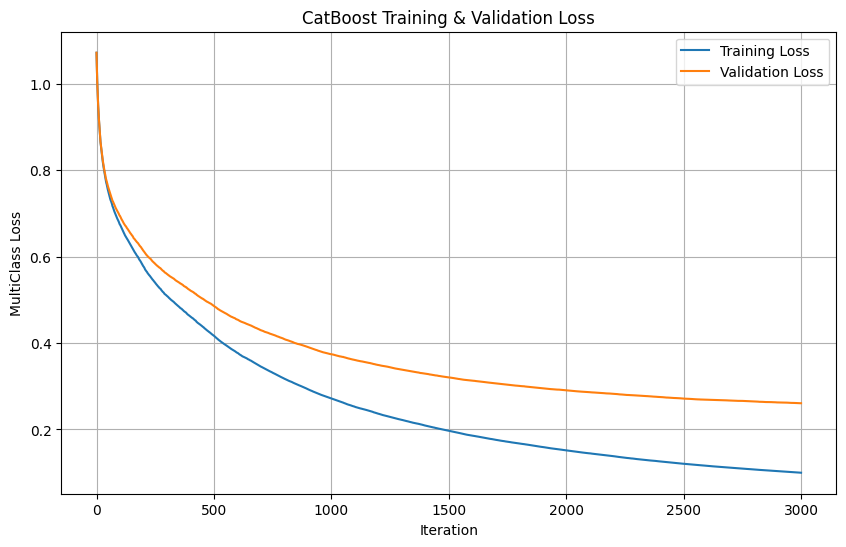

In [18]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [19]:
y_pred = model.predict(X_test)

### Confusion Matrix

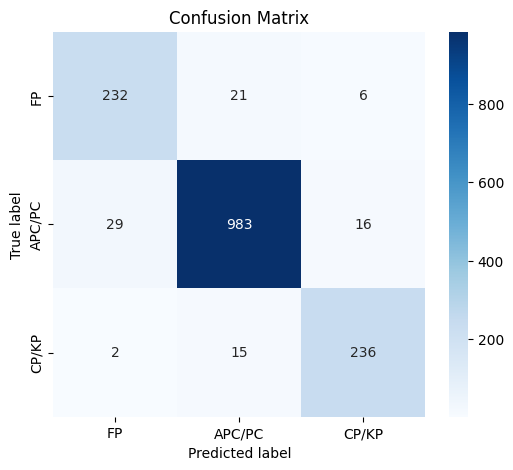

In [20]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [22]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision Score: {:.2f}%".format(precision * 100))
print("Recall Score: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 94.22%
Precision Score: 94.26%
Recall Score: 94.22%
F1 Score: 94.24%


In [23]:
model.save_model("TESS_Model.onnx", format="onnx")